# Faiss (Facebook AI Similarity Search)

This notebook focuses on the **Similarity Search** pipeline, a **transfer learning** approach for multi-label plant species classification.

We utilize [Faiss](https://ai.meta.com/tools/faiss/) to perform **Approximate Nearest Neighbor Search (ANNS)** on image embeddings extracted from a fine-tuned Vision Transformer (ViT).  

By leveraging **self-supervised feature representations**, we can classify unseen test images **without retraining** the model.

![diagram](../images/pytorch-webinar-diagram.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from plantclef.config import get_device
import pandas as pd

pd.set_option("display.max_colwidth", 40)

print(f"PyTorch Version: {torch.__version__}")
device = get_device()
print(f"Using device: {device}")

### Loading embeddings

We load precomputed **ViT embeddings** for both the training and test sets.  
The training embeddings correspond to **single-label plant images**, while the test embeddings were generated from **3x3 image tiles of multi-label vegetation plots**.

In [ ]:
import polars as pl
from plantclef.pytorch.data_catalog import make_dataset
from plantclef.embed.workflow import PipelineConfig


######################

subset = "val"

if subset == "val":
    subset_embeddings_path = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/processed/plantclef2024/val/embeddings.parquet"
    subset_predictions_path = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/processed/plantclef2024/val/predictions.parquet"

embed_df = pl.read_parquet(subset_embeddings_path)

#####################

# from plantclef.pytorch import data_catalog
cfg = PipelineConfig()
ds = make_dataset(name="plantclef2024", load_all_subsets=False, subset=subset)

catalog_cols = {"label_idx", "species_id", "species", "image_name", "image_path"}
drop_cols = list(set(ds.dataset.features.keys()) - catalog_cols)
print(drop_cols)
train_catalog = ds.dataset.remove_columns(drop_cols)
train_catalog_df = train_catalog.to_pandas()
train_catalog_df.head(5)
embed_df = embed_df.join(
    pl.from_pandas(
        train_catalog_df.drop(columns=["label_idx", "species_id", "species"])
    ),
    how="inner",
    on="image_name",
)

100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


['latitude', 'obs_id', 'organ', 'learn_tag', '__index_level_0__', 'image', 'genus', 'author', 'family', 'altitude', 'longitude']


### Load test quadrat images for querying

In [ ]:
from datasets import Dataset as HFDataset
import os
import torch

test_embeddings_path = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/embeddings/full_test/test_grid_3x3_embeddings"

test_ds = HFDataset.load_from_disk(test_embeddings_path)

query_image_root_dir = "/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/competition-metadata/PlantCLEF2025_test_images/PlantCLEF2025_test_images"
test_ds = test_ds.map(
    lambda x: {"image_path": os.path.join(query_image_root_dir, x["image_name"])}
)


test_df = test_ds.to_pandas()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18945 entries, 0 to 18944
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  18945 non-null  object
 1   embeddings  18945 non-null  object
 2   logits      18945 non-null  object
 3   tile        18945 non-null  int64 
 4   image_path  18945 non-null  object
dtypes: int64(1), object(4)
memory usage: 740.2+ KB


In [ ]:
test_df.head()

image_name  \
0  2024-CEV3-20240602.jpg   
1  2024-CEV3-20240602.jpg   
2  2024-CEV3-20240602.jpg   
3  2024-CEV3-20240602.jpg   
4  2024-CEV3-20240602.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                embeddings  \
0  [0.8906070590019226, -0.489795982837677, -1.570011854171753, -1.8004376888275146, 0.38558971881866455, 0.8664846420288086, -1.1120789051055908, -0.7297578454017639, -0.012218551710247993, -0.4080791175365448, -0.04938913881778717, -1.2592347860336304, -1.0681453943252563, -0.7655613422393799, 0.9916516542434692, -0.11250945925712585, -0.6446520686149597, -0.07316772639751434, -0.30966994166374207, 0.2725190222263336, -0.05505916848778725, 1.2755488157272339, 0.8588393330574036, 0.8276700973510742, -0.14289799332618713, 0.08937473595142365, -1.1185280084609985, -0.2334858477115631, -0.9913045167922974, -1.5572227239608765, -0.042439598590135574, 0.36138197779655457, 0.5760548114776611, 0.05744680389761925, -0.8814634084701538, 0.14372533559799194, -0.4106905460357666, -0.023594368249177933, 0.114301398396492, -1.0856797695159912, -1.0030802488327026, -0.4780075252056122, 0.9809963703155518, -0.40678611397743225, 1.1214895248413086, -0.16413404047489166, 2.1607553958892822, -1.9110053777694702, -0.016739217564463615, -0.014020438306033611, 0.525755763053894, 0.7179474234580994, 0.9194038510322571, 1.1444008350372314, 0.10144991427659988, -0.24720361828804016, 0.5040621161460876, 1.3279024362564087, -0.05690160021185875, -0.29242315888404846, 0.1120745837688446, -0.32851430773735046, -0.23351570963859558, 0.11195770651102066, -0.6580687165260315, -1.0990115404129028, 0.6212208867073059, 0.6110418438911438, 1.2321803569793701, -1.3203637599945068, -0.3986373245716095, -0.5109138488769531, 0.7342885136604309, 0.5232835412025452, 0.1452857404947281, -0.655102550983429, 0.18549370765686035, -0.0874844565987587, 0.5858707427978516, 0.6516444683074951, 0.16163526475429535, -0.196255162358284, 0.480461448431015, -0.74252867

### Similarity Search using Faiss 

We use the `FaissClassifier` class to perform **nearest neighbor search** in embedding space.  
Each test tile's embedding is compared to the full training set, and we retrieve the top-*K* most similar embeddings.

This allows us to infer potential species labels based on visual similarity alone.

In [ ]:
import numpy as np
from plantclef.faiss_tools.classifier import FaissClassifier
from plantclef.config import get_device

train_df = embed_df

# similarity seearch using FAISS
nn_classifier = FaissClassifier(embed_df)

# convert test embeddings to torch tensor
embs_array = np.array(test_df["embeddings"].tolist(), dtype=np.float32)
query_embs = torch.tensor(embs_array, device=get_device())
query_embs.shape

torch.Size([18945, 768])

### Retrieving top-*K* predictions

We run the Faiss classifier with `k=5`, which returns:
- The top 5 most similar training images for each test tile.
- The cosine similarity scores for each match.

In [ ]:
# top 5 predictions for each embedding
preds, similarities = nn_classifier.make_prediction(query_embs, k=5)
print(preds[:2], similarities[:2])
print(preds.shape, similarities.shape)
print(f"type(preds) = {type(preds)}")
print(f"type(similarities) = {type(similarities)}")

[['/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1394317/69f4b3280733d7c7325a6de2916ef6ae186efaa6.jpg'
  '/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1360211/260e055ae65d135632bf33be2625270c28d9b74f.jpg'
  '/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1398723/e720e4321fa193d68731a7140896d78eb4e07c6c.jpg'
  '/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1394850/888a0af6ba4088075c939747d41d47ce2fbeac4a.jpg'
  '/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1395066/4b20f43d781bfca4d92ed3357e82833f1dd77d59.jpg']
 ['/

### Builing the Faiss classification DataFrame

We convert Faiss predictions into a classification-friendly format:
- For each test tile, we store its top-*K* predicted training image names.
- We map these to their corresponding `species_id` labels.
- Similarity scores are also included to weight or filter predictions.

This dataframe will power our visualizations and final submission.

In [8]:
import numpy as np


# create dataframe with faiss classifications
def create_classification_dataframe(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    predictions: np.array,
    similarities: np.array,
):
    """
    Creates a classification DataFrame with Faiss predictions, similarities, and resolved species IDs.

    :param train_df: Train DataFrame with image_name to species_id mapping
    :param test_df: Test DataFrame (contains image_name, data, embeddings, etc.)
    :param predictions: np.array of shape (N, K) with predicted image names
    :param similarities: np.array of shape (N, K) with similarity scores
    :return: DataFrame with columns: predictions, similarities, species_ids
    """
    cls_test_df = test_df.copy()
    cls_test_df["predictions"] = predictions.tolist()
    cls_test_df["similarities"] = similarities.tolist()
    # create lookup dictionary
    image_to_species = dict(zip(train_df["image_path"], train_df["species_id"]))
    # map preds to species_id
    species_ids = []
    for row in cls_test_df["predictions"]:
        row_species = [image_to_species.get(img_name, None) for img_name in row]
        species_ids.append(row_species)
    # add to DataFrame
    cls_test_df["pred_species_ids"] = species_ids
    return cls_test_df

## (9:57 AM Sun May 18th, 2025) -- Left off here, trying to find where I kept the image labels (`species_id` column) for the `create_classification_dataframe` function that combines top-k query faiss image search results into classification results eligible for submission.

In [ ]:
faiss_df = create_classification_dataframe(
    train_catalog_df,
    test_df,
    preds,
    similarities,
)
faiss_df.head()

image_name  \
0  2024-CEV3-20240602.jpg   
1  2024-CEV3-20240602.jpg   
2  2024-CEV3-20240602.jpg   
3  2024-CEV3-20240602.jpg   
4  2024-CEV3-20240602.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                embeddings  \
0  [0.8906070590019226, -0.489795982837677, -1.570011854171753, -1.8004376888275146, 0.38558971881866455, 0.8664846420288086, -1.1120789051055908, -0.7297578454017639, -0.012218551710247993, -0.4080791175365448, -0.04938913881778717, -1.2592347860336304, -1.0681453943252563, -0.7655613422393799, 0.9916516542434692, -0.11250945925712585, -0.6446520686149597, -0.07316772639751434, -0.30966994166374207, 0.2725190222263336, -0.05505916848778725, 1.2755488157272339, 0.8588393330574036, 0.8276700973510742, -0.14289799332618713, 0.08937473595142365, -1.1185280084609985, -0.2334858477115631, -0.9913045167922974, -1.5572227239608765, -0.042439598590135574, 0.36138197779655457, 0.5760548114776611, 0.05744680389761925, -0.8814634084701538, 0.14372533559799194, -0.4106905460357666, -0.023594368249177933, 0.114301398396492, -1.0856797695159912, -1.0030802488327026, -0.4780075252056122, 0.9809963703155518, -0.40678611397743225, 1.1214895248413086, -0.16413404047489166, 2.1607553958892822, -1.9110053777694702, -0.016739217564463615, -0.014020438306033611, 0.525755763053894, 0.7179474234580994, 0.9194038510322571, 1.1444008350372314, 0.10144991427659988, -0.24720361828804016, 0.5040621161460876, 1.3279024362564087, -0.05690160021185875, -0.29242315888404846, 0.1120745837688446, -0.32851430773735046, -0.23351570963859558, 0.11195770651102066, -0.6580687165260315, -1.0990115404129028, 0.6212208867073059, 0.6110418438911438, 1.2321803569793701, -1.3203637599945068, -0.3986373245716095, -0.5109138488769531, 0.7342885136604309, 0.5232835412025452, 0.1452857404947281, -0.655102550983429, 0.18549370765686035, -0.0874844565987587, 0.5858707427978516, 0.6516444683074951, 0.16163526475429535, -0.196255162358284, 0.480461448431015, -0.74252867

In [ ]:
from plantclef.plotting import plot_image_tiles
import random

random.seed(42)

query_image_names = faiss_df["image_name"].unique().tolist()
random.sample(query_image_names, 1)

# select images from test set
# image_names = ["CBN-Pyr-03-20230706.jpg", "CBN-can-E6-20230706.jpg"]
image_name_query = random.sample(query_image_names, 1)
faiss_image_df = faiss_df[faiss_df["image_name"].isin(image_name_query)]
faiss_image_df.shape
faiss_image_df.head(5)

image_name  \
918  CBN-PdlC-A5-20190909.jpg   
919  CBN-PdlC-A5-20190909.jpg   
920  CBN-PdlC-A5-20190909.jpg   
921  CBN-PdlC-A5-20190909.jpg   
922  CBN-PdlC-A5-20190909.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      embeddings  \
918           [1.1175791025161743, 0.6613186597824097, 0.5164704918861389, 0.7782418727874756, -0.5815093517303467, -0.3168005645275116, -0.7462148666381836, -0.8985679149627686, 0.8725504875183105, 0.2540561854839325, 0.8191536664962769, -0.9968841671943665, 0.2418236881494522, 0.5189133882522583, -0.4133675694465637, 0.6682562232017517, 0.5123817920684814, 0.443586140871048, -0.145134836435318, -0.0715770572423935, 0.8060041666030884, -0.5533806085586548, 0.1185254156589508, 0.13211271166801453, -0.1247093677520752, 0.7261916399002075, -0.2655201852321625, -0.3538164794445038, -1.2039976119995117, 1.0061606168746948, -0.4371117949485779, 0.4998552203178406, 1.3033301830291748, -0.48577451705932617, -0.6578036546707153, 1.0530729293823242, 1.0432915687561035, -0.8743462562561035, 0.7506049871444702, -0.9179481267929077, -1.7177215814590454, 1.2409929037094116, -0.46057143807411194, -0.8987292647361755, 0.5888441801071167, -0.11118518561124802, 1.7475446462631226, -0.5172976851463318, 1.2611846923828125, -0.48669442534446716, 0.8760380744934082, 0.3906123638153076, 0.35992321372032166, -0.3230317234992981, 0.8863133788108826, -0.2517896294593811, -0.3495084345340729, -0.12741656601428986, -1.06923508644104, 0.22856245934963226, 1.2402271032333374, 0.11525210738182068, 0.10211393982172012, 0.7144339680671692, -0.926927924156189, 0.6754741072654724, 1.0733027458190918, 0.6201773881912231, -0.200189009308815, -1.0686880350112915, 0.14964990317821503, 0.3280084729194641, 0.19706018269062042, 0.6632611155509949, -1.2455304861068726, -0.005010679364204407, 0.655113697052002, -1.1075539588928223, -0.6650173664093018, -0.1399824023246765, -0.2222333699464798, -1.0655990839004517, -0.12303853780031204, 0.29441177845

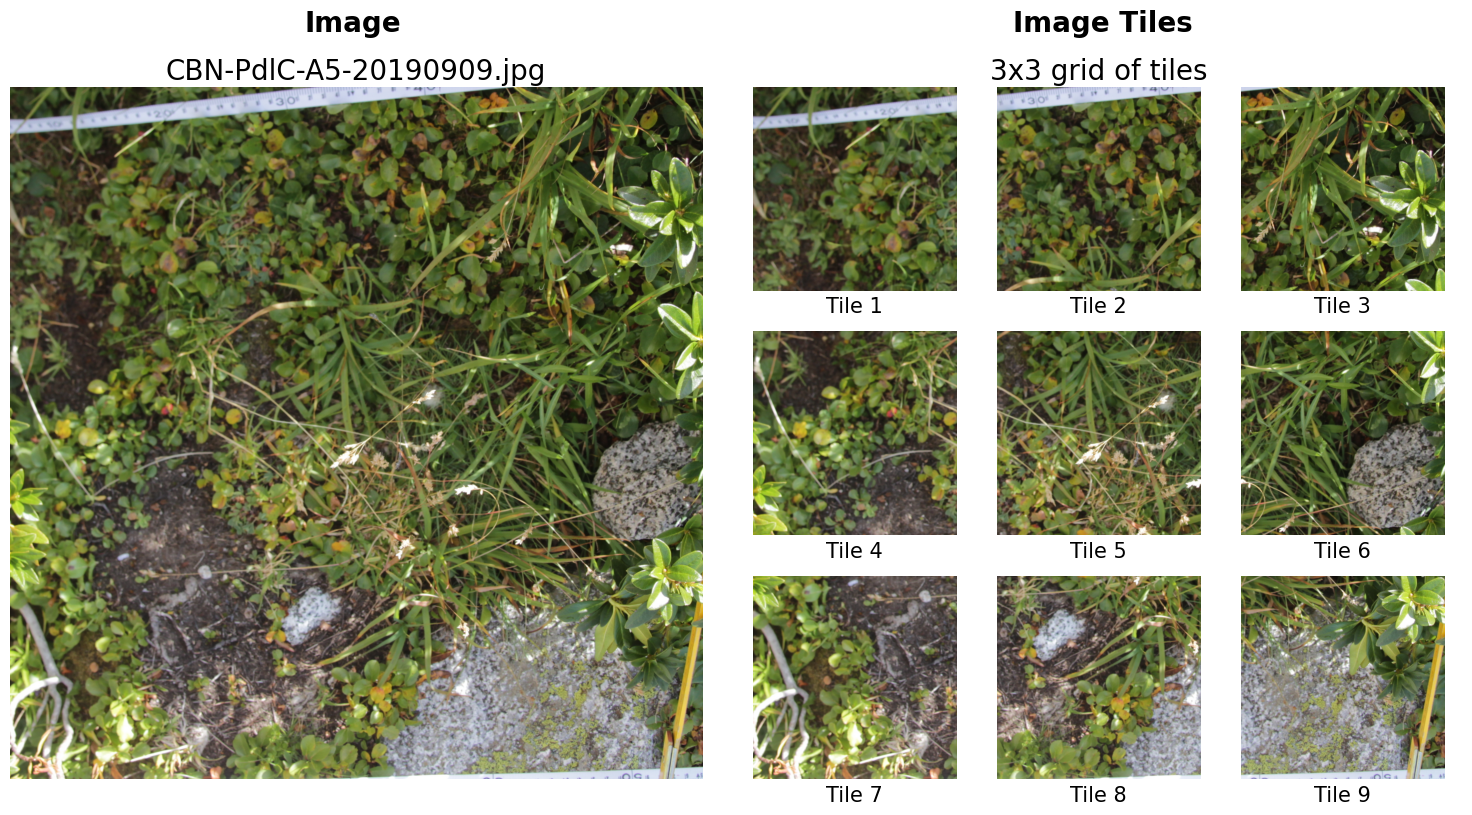

In [ ]:
# show image tiles
plot_image_tiles(
    faiss_image_df,
    idx=0,
    path_col="image_path",
    grid_size=3,
)

### Visualizing Faiss predictions

We display the top Faiss-predicted species for each tile using both:
- Training reference images
- Predicted species labels

This allows us to assess prediction quality and inspect visual matches.

In [ ]:
faiss_image_df.head(5)

image_name  \
918  CBN-PdlC-A5-20190909.jpg   
919  CBN-PdlC-A5-20190909.jpg   
920  CBN-PdlC-A5-20190909.jpg   
921  CBN-PdlC-A5-20190909.jpg   
922  CBN-PdlC-A5-20190909.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      embeddings  \
918           [1.1175791025161743, 0.6613186597824097, 0.5164704918861389, 0.7782418727874756, -0.5815093517303467, -0.3168005645275116, -0.7462148666381836, -0.8985679149627686, 0.8725504875183105, 0.2540561854839325, 0.8191536664962769, -0.9968841671943665, 0.2418236881494522, 0.5189133882522583, -0.4133675694465637, 0.6682562232017517, 0.5123817920684814, 0.443586140871048, -0.145134836435318, -0.0715770572423935, 0.8060041666030884, -0.5533806085586548, 0.1185254156589508, 0.13211271166801453, -0.1247093677520752, 0.7261916399002075, -0.2655201852321625, -0.3538164794445038, -1.2039976119995117, 1.0061606168746948, -0.4371117949485779, 0.4998552203178406, 1.3033301830291748, -0.48577451705932617, -0.6578036546707153, 1.0530729293823242, 1.0432915687561035, -0.8743462562561035, 0.7506049871444702, -0.9179481267929077, -1.7177215814590454, 1.2409929037094116, -0.46057143807411194, -0.8987292647361755, 0.5888441801071167, -0.11118518561124802, 1.7475446462631226, -0.5172976851463318, 1.2611846923828125, -0.48669442534446716, 0.8760380744934082, 0.3906123638153076, 0.35992321372032166, -0.3230317234992981, 0.8863133788108826, -0.2517896294593811, -0.3495084345340729, -0.12741656601428986, -1.06923508644104, 0.22856245934963226, 1.2402271032333374, 0.11525210738182068, 0.10211393982172012, 0.7144339680671692, -0.926927924156189, 0.6754741072654724, 1.0733027458190918, 0.6201773881912231, -0.200189009308815, -1.0686880350112915, 0.14964990317821503, 0.3280084729194641, 0.19706018269062042, 0.6632611155509949, -1.2455304861068726, -0.005010679364204407, 0.655113697052002, -1.1075539588928223, -0.6650173664093018, -0.1399824023246765, -0.2222333699464798, -1.0655990839004517, -0.12303853780031204, 0.29441177845

In [13]:
train_catalog_df

image_path  \
0      /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1396710/f16927852fce6a744871f046efb9a6be35a4c009.jpg   
1      /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1396710/7098c649ad164ddb60d3554a01226d6e981f1a72.jpg   
2      /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1396710/9649bd74996dd03d0f014744082227dbf703ca8b.jpg   
3      /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1396710/dc79ffd2af5bcce39a034efbb5c53d371063a079.jpg   
4      /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1396710/b5fa87707d20dce4e4828c452f34131a4a329aa7.jpg   
...                                                                                                                                                                                                   ...   
51189  /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1361255/58809d64f324d5725d9a5d66b9045c9256264b56.jpg   
51190  /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1361255/13f38b41558f39e81f0cdb5a131190b4d7bae711.jpg   
51191  /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1361255/c72183a56c3c8f5add96cf4d4c2052ba45fad4b6.jpg   
51192  /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1361255/11ae2fb5cb8c03a3a794720662cf53de3ee706da.jpg   
51193  /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1361255/24535bddcb166a84c3f6d5d9b28df155334242a3.jpg   

       label_idx                                    image_name  species_id  \
0           4826  f16927852fce6a744871f046efb9a6be35a4c009.jpg     1396710   
1           4826  7098c649ad164ddb60d3554a01226d6e981f1a72.jpg     1396710   
2           4826  9649bd74996dd03d0f014744082227dbf703ca8b.jpg     1396710   
3           4826  dc79ffd2af5bcce39a034efbb5c53d371063a079.jpg     1396710   
4           4826  b5fa87707d20dce4e4828c452f34131a4a329aa7.jpg     1396710   
...          ...                                           ...         ...   
51189       1864  58809d64f324d5725d9a5d66b9045c9256264b56.jpg     1361255   
51190       1864  13f38b41558f39e81f0cdb5a131190b4d7bae711.jpg     1361255   
51191       1864  c72183a56c3c8f5add96cf4d4c2052ba45fad4b6.jpg     1361255   
51192       1864  11ae2fb5cb8c03a3a794720662cf53de3ee706da.jpg     1361255   
51193       1864  24535bddcb166a84c3f6d5d9b28df155334242a3.jpg     1361255   

                      species  
0            Taxus baccata L.  
1            Taxus baccata L.  
2            Taxus baccata L.  
3            Taxus baccata L.  
4            Taxus baccata L.  
...                       ...  
51189  Zostera noltii Hornem.  
51190  Zostera noltii Hornem.  
51191  Zostera noltii Hornem.  
51192  Zostera noltii Hornem.  
51193  Zostera noltii Hornem.  

[51194 rows x 5 columns]

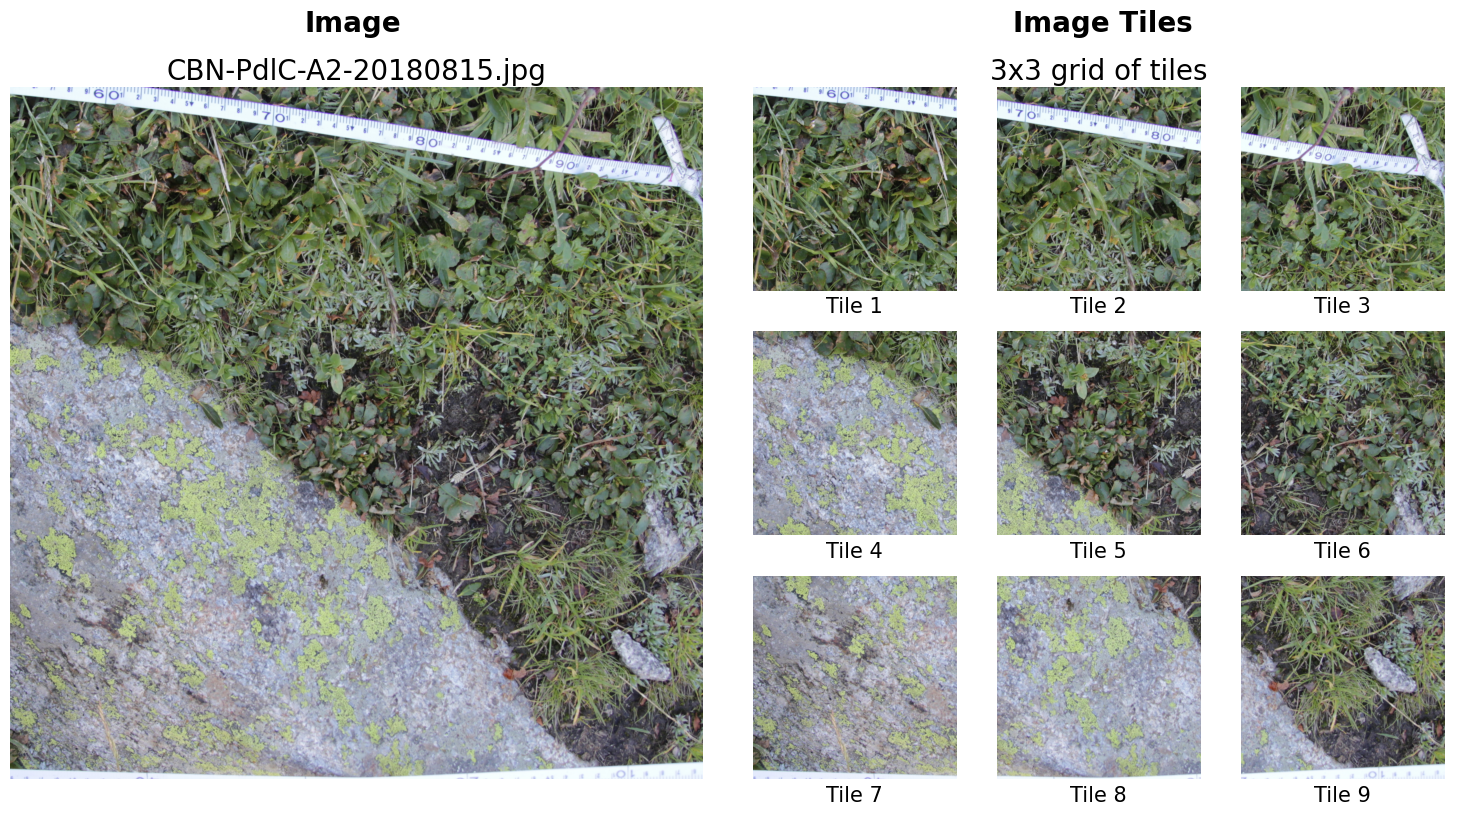

In [ ]:
idx = 35

plot_image_tiles(
    faiss_df,
    idx=idx,
    path_col="image_path",
    grid_size=3,
)

In [ ]:
from plantclef.plotting import plot_faiss_classifications
import matplotlib.pyplot as plt

# plot tiles and image classifications from faiss
plot_faiss_classifications(
    train_catalog_df,
    faiss_df,
    idx=idx,
    path_col="image_path",
    grid_size=3,
    figsize=(20, 30),
)

fig = plt.gcf()

ValueError: Image path does not exist: /teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1355989/b8145ef1873c7103503dde7110736bbb486b4f05.jpg

### How Faiss-based classification works

We're using Faiss to perform ***K*-Nearest Neighbor Search** on image embeddings.
- Faiss finds the top-*K* training embeddings most similar to each test tile.
- Each training image has a single `species_id`.
- By mapping predictions back to species, we achieve multi-label classification without any training.

This strategy leverages the power of **transfer learning + visual similarity** for inference.

In [15]:
# images names predicted in the first tile
img_names = faiss_image_df.predictions.iloc[0]
# species_ids of predictions
preds = faiss_image_df["pred_species_ids"].iloc[0]

for i, name in enumerate(img_names):
    print(f"{name}: {preds[i]}")

/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1729952/b1395cad6ae36b1ab048e3246daeea402bc6e827.jpg: 1729952
/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1358701/84a6c146281a737cba55ed5d1bdbefacf933d4ed.jpg: 1358701
/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1394443/0da6cc9662c128e71a30dcf1120e59b1972ab836.jpg: 1394443
/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1646703/8ef142cd99666bfab1190d50a875fc3ac5610b7f.jpg: 1646703
/teamspace/studios/this_studio/plantclef-vision/data/plantclef2025/PlantCLEF2024singleplanttrainingdata_800_max_side_size/images_max_side_800/1646703/60b34e3263783ca6fb15d1002d7071c558

### Creating submission CSV

We generate a submission file in the required format for the PlantCLEF 2025 competition.  
Each record includes a plot ID and the predicted species IDs aggregated from tile-level predictions.

**Note:** This submisison DataFrame is missing many test images because we're using a subset of the test set with 200 images. The real test set for the 2025 competition has **2,105 images**.

In [16]:
faiss_df.head(5)

image_name                                         embeddings  \
0  2024-CEV3-20240602.jpg  [0.8906070590019226, -0.489795982837677, -1.57...   
1  2024-CEV3-20240602.jpg  [-0.8477969169616699, 0.9200248122215271, -0.5...   
2  2024-CEV3-20240602.jpg  [-0.10401648283004761, 0.773762047290802, -0.9...   
3  2024-CEV3-20240602.jpg  [-1.3204526901245117, -0.123285211622715, -0.7...   
4  2024-CEV3-20240602.jpg  [-0.700384795665741, -0.6505104303359985, 0.88...   

                                              logits  tile  \
0  {'1355869': None, '1355873': None, '1355880': ...     0   
1  {'1355869': None, '1355873': None, '1355880': ...     1   
2  {'1355869': None, '1355873': None, '1355880': ...     2   
3  {'1355869': None, '1355873': None, '1355880': ...     3   
4  {'1355869': None, '1355873': None, '1355880': ...     4   

                                          image_path  \
0  /teamspace/studios/this_studio/plantclef-visio...   
1  /teamspace/studios/this_studio/plantclef-visio...   
2  /teamspace/studios/this_studio/plantclef-visio...   
3  /teamspace/studios/this_studio/plantclef-visio...   
4  /teamspace/studios/this_studio/plantclef-visio...   

                                         predictions  \
0  [/teamspace/studios/this_studio/plantclef-visi...   
1  [/teamspace/studios/this_studio/plantclef-visi...   
2  [/teamspace/studios/this_studio/plantclef-visi...   
3  [/teamspace/studios/this_studio/plantclef-visi...   
4  [/teamspace/studios/this_studio/plantclef-visi...   

                                        similarities  \
0  [0.4395297169685364, 0.43007799983024597, 0.42...   
1  [0.4100256860256195, 0.39866751432418823, 0.39...   
2  [0.5458512306213379, 0.4452388882637024, 0.441...   
3  [0.4188607335090637, 0.415363609790802, 0.3992...   
4  [0.3751702904701233, 0.37512752413749695, 0.37...   

                                pred_species_ids  
0  [1394317, 1360211, 1398723, 1394850, 1395066]  
1  [1389859, 1392662, 1392662, 1389859, 1617142]  
2  [1392662, 1392662, 1361640, 1617142, 1390760]  
3  [1394317, 1481925, 1394317, 1395063, 1360211]  
4  [1393879, 1362331, 1394828, 1728724, 1390795]

In [18]:
## Experimental

# from collections import Counter

# species_col = "pred_species_ids"
# grouped = faiss_df.groupby("image_name")[species_col].apply(list)

# image_name = grouped.index[0]
# species_id_lists = grouped[0]

image_name
2024-CEV3-20240602.jpg      [[1394317, 1360211, 1398723, 1394850, 1395066]...
CBN-PdlC-A1-20130807.jpg    [[1528543, 1363056, 1392628, 1517773, 1390793]...
CBN-PdlC-A1-20130903.jpg    [[1743465, 1390793, 1418612, 1363266, 1744842]...
CBN-PdlC-A1-20140721.jpg    [[1741880, 1391331, 1396030, 1741880, 1394725]...
CBN-PdlC-A1-20140811.jpg    [[1396030, 1741880, 1390793, 1394540, 1741880]...
                                                  ...                        
RNNB-8-5-20240118.jpg       [[1357277, 1365431, 1396759, 1396759, 1363840]...
RNNB-8-6-20240118.jpg       [[1426088, 1356598, 1356598, 1722441, 1722441]...
RNNB-8-7-20240118.jpg       [[1357724, 1357724, 1357724, 1457488, 1398791]...
RNNB-8-8-20240118.jpg       [[1363840, 1364074, 1356866, 1393587, 1425420]...
RNNB-8-9-20240118.jpg       [[1396464, 1397504, 1397504, 1422941, 1652912]...
Name: pred_species_ids, Length: 2105, dtype: object

In [37]:
from plantclef.config import create_submission_csv

output_path = f"/teamspace/studios/this_studio/plantclef-vision/data/submissions/faiss_knn_{subset}/submission.csv"

submission_df = create_submission_csv(
    faiss_df, save_csv=True, output_path=output_path, limit_top_k=15
)
submission_df.head(10)

Submission file saved to: ../data/submission/submission.csv


quadrat_id                                        species_ids
0    2024-CEV3-20240602.jpg  [1360211, 1392662, 1395063, 1394317, 1394828, ...
1  CBN-PdlC-A1-20130807.jpg  [1390793, 1396030, 1395972, 1395974, 1529410, ...
2  CBN-PdlC-A1-20130903.jpg  [1390793, 1363266, 1743465, 1418612, 1362811, ...
3  CBN-PdlC-A1-20140721.jpg  [1529116, 1741880, 1396030, 1390793, 1517486, ...
4  CBN-PdlC-A1-20140811.jpg  [1412857, 1396030, 1356350, 1741880, 1390793, ...
5  CBN-PdlC-A1-20140901.jpg  [1652912, 1356350, 1363266, 1722509, 1362811, ...
6  CBN-PdlC-A1-20150701.jpg  [1652912, 1390793, 1396030, 1358655, 1363016, ...
7  CBN-PdlC-A1-20150720.jpg  [1396417, 1412857, 1394886, 1517486, 1392767, ...
8  CBN-PdlC-A1-20150831.jpg  [1396030, 1419104, 1412857, 1391151, 1391331, ...
9  CBN-PdlC-A1-20160705.jpg  [1363266, 1390765, 1390793, 1396030, 1529410, ...

In [42]:
# len(submission_df.iloc[1]["species_ids"])

# limit_top_k = 20

# new_df = submission_df.head(5).apply(lambda x: parse_integer_list(x["species_ids"]), axis=1)
# new_df.apply(lambda x: len(x))
# type(new_df.iloc[0][0])
# submission_df.apply?

324

In [ ]:
# len(submission_df.iloc[1]["species_ids"])
# limit_top_k = 20

# new_df = submission_df.head(5).apply(lambda x: x["species_ids"][:limit_top_k], axis=1)
# new_df.apply(lambda x: len(x))
# submission_df.apply?


324